# Thesis Code — Profit-Seeking Hedging under LNMRV

**Author:** Stephan Liebenberg & Lamees Moola

**Purpose:** Reproducible pipeline corresponding to Chapters 5–7 (Methodology, Comparative Analysis, Empirics).

**High-level steps**
1. Data ingestion & preprocessing (Sec. 6.1; references to Sec. 5.3 EWMA proxy)
2. LNMRV model specification (Sec. 5.1)
3. Likelihood construction (Sec. 5.2)
4. Calibration / Estimation (Sec. 5.3)
5. Monte Carlo simulation (Sec. 5.4)
6. Black–Scholes benchmark hedging (Sec. 6.2)
7. Neural network hedging (Sec. 6.3)
8. Simulation-based comparative analysis (Sec. 7.2)
9. Out-of-sample August evaluation (Sec. 7.3)
10. Artifact export (all figures & tables referenced in manuscript)

**0. Notebook Setup**

In [ ]:
# --- Imports & setup ---
import os, math, itertools, json, pathlib
from dataclasses import dataclass
from typing import Tuple, Dict, Any
from IPython.display import display


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reproducibility
np.random.seed(42)

# Plot style 
plt.rcParams.update({
    "figure.figsize": (9, 4.5),
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "savefig.dpi": 150,
})

# === Paths ===
PROJECT_DIR = pathlib.Path(".").resolve()
DATA_DIR    = PROJECT_DIR / "data"
FIG_DIR     = PROJECT_DIR / "figs_thesis"
TAB_DIR     = PROJECT_DIR / "tables_thesis"

for d in [FIG_DIR, TAB_DIR]:
    d.mkdir(exist_ok=True, parents=True)

print(f"Working in: {PROJECT_DIR}")
print(f"Data dir:   {DATA_DIR}")
print(f"Figures →   {FIG_DIR}")
print(f"Tables  →   {TAB_DIR}")

Working in: /Users/lamees/Desktop/Campus/Project/Final code
Data dir:   /Users/lamees/Desktop/Campus/Project/Final code/data
Figures →   /Users/lamees/Desktop/Campus/Project/Final code/figs_thesis
Tables  →   /Users/lamees/Desktop/Campus/Project/Final code/tables_thesis


**Variable naming**
- Prices: `S1_t`, `S2_t`; vectors `S_t = (S1_t, S2_t)`
- Volatilities: `sigma1_t`, `sigma2_t`; vectors `sigma_t`
- Parameters:  
  `mu1, mu2, kappa1, kappa2, alpha1, alpha2, xi1, xi2, rho_S1S2, rho_S1sigma1, rho_S2sigma2, rho_sigma1sigma2`
- Correlation matrix: `R` (4×4 for [S1, S2, sigma1, sigma2] shocks)
- Time: `dt = 1/252`, horizon `T_days`, steps `K`, rebalancing times `t_k`
- Risk-free rate: `r`
- EWMA: `lambda_ewma`, recursive variance `vhat_t`, annualised `sigmahat_t = sqrt(252*vhat_t)`
- NN: parameters `theta`; hedge `phi_t = (phi1_t, phi2_t)`
- P&L: `PnL = V_T - H_T`


**1. Market Data and Preliminary Analysis (Sec. 6.1)**

**Load and align observed data**
- Use uploaded Bloomberg files for MTN and Vodacom (year + August).
- Compute log-returns and EWMA vol (infinite-decay recursion).
- Save figures:
  - **Figure 6.1** Historical prices
  - **Figure 6.2** EWMA annualised volatility


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib

# === Paths ===
PROJECT_DIR = pathlib.Path(".").resolve()
DATA_DIR    = PROJECT_DIR / "data"
FIG_DIR     = PROJECT_DIR / "figs_thesis"
TAB_DIR     = PROJECT_DIR / "tables_thesis"
FIG_DIR.mkdir(exist_ok=True, parents=True)
TAB_DIR.mkdir(exist_ok=True, parents=True)

file_mtn_year = DATA_DIR / "JSE-GP-MTN-YEAR.xlsx"
file_vod_year = DATA_DIR / "JSE-GP-VOD-YEAR.xlsx"

# === Loader for the data ===
def load_bbg_xlsx(path):
    """Load Bloomberg-style XLSX with 'Date' and 'Last Price' columns using comma decimals."""
    df = pd.read_excel(path, sheet_name=0, header=0)
    df.columns = [c.strip() for c in df.columns]

    # Replace comma decimals and coerce to float
    df["Last Price"] = (
        df["Last Price"]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .astype(float)
    )

    df["Date"] = pd.to_datetime(df["Date"], errors="coerce").dt.tz_localize(None)
    df = df.dropna(subset=["Date", "Last Price"]).sort_values("Date")
    df = df.set_index("Date")
    return df.rename(columns={"Last Price": "price"})

# === Load ===
mtn = load_bbg_xlsx(file_mtn_year).rename(columns={"price": "MTN"})
vod = load_bbg_xlsx(file_vod_year).rename(columns={"price": "VOD"})
prices = mtn.join(vod, how="inner").dropna()

print(f"Rows: {len(prices)} | Range: {prices.index.min().date()} → {prices.index.max().date()}")
print(prices.head())

# === Log returns ===
rets = np.log(prices / prices.shift(1)).dropna()

# === EWMA volatility (λ = 0.94) ===
lambda_ewma = 0.94
alpha = 1 - lambda_ewma
vhat = rets.pow(2).ewm(alpha=alpha, adjust=False).mean()
sigmahat = vhat.pow(0.5) * np.sqrt(252)

# === Plot 6.1: Historical prices ===
ax = prices.plot(title="Historical price series of MTN and VOD")
ax.set_xlabel("")
plt.tight_layout()
plt.savefig(FIG_DIR / "Fig6_1_Historic_Prices.png", dpi=150)
plt.close()

# === Plot 6.2: EWMA volatility ===
ax = (sigmahat * 100).plot(title="EWMA Annualised Volatility (%, λ=0.94)")
ax.set_ylabel("%")
ax.set_xlabel("")
plt.tight_layout()
plt.savefig(FIG_DIR / "Fig6_2_EWMA_Vol.png", dpi=150)
plt.close()

Rows: 250 | Range: 2024-07-31 → 2025-07-31
               MTN      VOD
Date                       
2024-07-31  7911.0  10222.0
2024-08-01  7736.0   9928.0
2024-08-02  7514.0   9825.0
2024-08-05  7461.0   9722.0
2024-08-06  7270.0   9729.0


In [ ]:
# === August files ===
file_mtn_aug = DATA_DIR / "JSE-GP-MTN-AUG.xlsx"
file_vod_aug = DATA_DIR / "JSE-GP-VOD-AUG.xlsx"

# === Load August data & align ===
mtn_aug = load_bbg_xlsx(file_mtn_aug).rename(columns={"price": "MTN"})
vod_aug = load_bbg_xlsx(file_vod_aug).rename(columns={"price": "VOD"})

# Inner-join on common dates
prices_aug = (
    mtn_aug.join(vod_aug, how="inner")
           .dropna()
           .sort_index()
)

print(f"[AUG] Rows: {len(prices_aug)} | Range: {prices_aug.index.min().date()} → {prices_aug.index.max().date()}")
print(prices_aug.head())

# (Optional) quick sanity plots for August
ax = prices_aug.plot(title="August Prices: MTN vs VOD")
ax.set_xlabel("")
plt.tight_layout()
plt.savefig(FIG_DIR / "Fig6_1a_Historic_Prices_AUG.png", dpi=150)
plt.close()


[AUG] Rows: 20 | Range: 2025-08-01 → 2025-08-28
                MTN      VOD
Date                        
2025-08-01  15566.0  13682.0
2025-08-04  15382.0  13716.0
2025-08-05  15404.0  13510.0
2025-08-06  15915.0  13710.0
2025-08-07  16762.0  13907.0


**2. LNMRV Model Specification (Sec. 5.1)**

SDEs:
- dS_t^i = μ_i S_t^i dt + σ_t^i S_t^i dW_t^{S^i}
- dσ_t^i = κ_i(α_i - σ_t^i)dt + ξ_i σ_t^i dW_t^{σ^i}
- Corrs (incl. leverage; cross-vol correlation).
We discretise with Euler–Maruyama (full truncation for σ if needed).

In [ ]:
# ---- Parameter container ----
@dataclass
class LNMRVParams:
    mu1: float; mu2: float
    kappa1: float; kappa2: float
    alpha1: float; alpha2: float
    xi1: float; xi2: float
    rho_S1S2: float
    rho_S1sigma1: float; rho_S2sigma2: float
    rho_sigma1sigma2: float

# ---- Cholesky-style construction of a valid correlation matrix ----
def build_R(p: LNMRVParams) -> np.ndarray:
    """
    Construct a PSD correlation matrix R for [S1, S2, sig1, sig2] using a
    constructive factor U (R = U U^T). Matches the four thesis rhos:
      R[0,1] = rho_S1S2
      R[0,2] = rho_S1sigma1
      R[1,3] = rho_S2sigma2
      R[2,3] = rho_sigma1sigma2
    The other correlations are implied by the construction.
    """
    # Clamp to open interval (-1,1) for numerical safety
    r12 = float(np.tanh(p.rho_S1S2))
    r13 = float(np.tanh(p.rho_S1sigma1))
    r24 = float(np.tanh(p.rho_S2sigma2))
    r34 = float(np.tanh(p.rho_sigma1sigma2))

    # Precompute roots with small floors to avoid div/0
    eps = 1e-12
    s12 = np.sqrt(max(1.0 - r12**2, eps))
    s13 = np.sqrt(max(1.0 - r13**2, eps))

    # Row vectors u1..u4 (each unit length):
    # u1 dot u2 = r12, u1 dot u3 = r13, u2 dot u4 = r24, u3 dot u4 = r34
    u1 = np.array([1.0, 0.0, 0.0, 0.0])

    # u2 has components on e1,e2 to achieve r12 with u1
    u2 = np.array([r12, s12, 0.0, 0.0])

    # u3 has components on e1,e3 to achieve r13 with u1 (r23 becomes implied)
    u3 = np.array([r13, 0.0, s13, 0.0])

    # u4 must satisfy: u2·u4 = r24 and u3·u4 = r34.
    # Let u4 = [a, b, c, d]. We set a=0 for simplicity; then:
    #   b = r24 / s12
    #   c = r34 / s13
    # Choose d so that ||u4||=1, scaling (b,c) if needed to maintain feasibility.
    a = 0.0
    b = r24 / s12
    c = r34 / s13

    # If b^2 + c^2 >= 1, shrink (b,c) proportionally to sit just inside the unit circle.
    norm2 = b*b + c*c
    if norm2 >= 1.0:
        scale = np.sqrt((1.0 - 1e-12) / norm2)
        b *= scale
        c *= scale
        norm2 = b*b + c*c

    d = np.sqrt(max(1.0 - norm2, eps))
    u4 = np.array([a, b, c, d])

    # Assemble R = U U^T (unit diagonal by construction)
    U = np.vstack([u1, u2, u3, u4])
    R = U @ U.T

    
    R = 0.5 * (R + R.T)
    return R


**3. Likelihood Construction (Sec. 5.2)**

- Euler–Maruyama one-step Gaussian approximation:
  X_{t+Δt} | X_t ~ N(m_t, Σ_t)
- Implement m_t and Σ_t per the section, parameterised via Cholesky to ensure PD.
- Use EWMA proxies σ̂_t when constructing quasi-likelihood if required by calibration approach.


In [ ]:
# =========================
# Sec. 5.2 — Likelihood construction (LNMRV, Euler–Maruyama, Gaussian one-step)
# =========================
from dataclasses import dataclass
from typing import Tuple, Dict
import numpy as np
import pandas as pd

DT = 1.0/252.0
EPS_SIG = 1e-8          
JITTER = 1e-12         
LOG2PI = np.log(2.0*np.pi)

# ---- Transition mean m_t (Euler) ----
def transition_mean(S1, S2, s1, s2, p: LNMRVParams, dt=DT) -> np.ndarray:
    return np.array([
        S1 + p.mu1*S1*dt,
        S2 + p.mu2*S2*dt,
        s1 + p.kappa1*(p.alpha1 - s1)*dt,
        s2 + p.kappa2*(p.alpha2 - s2)*dt
    ], dtype=float)

# ---- Transition covariance Σ_t (Euler) ----
def transition_cov(S1, S2, s1, s2, p: LNMRVParams, dt=DT) -> np.ndarray:
    # local stds for the four coordinates (price, price, vol, vol)
    s1_ = max(float(s1), EPS_SIG)
    s2_ = max(float(s2), EPS_SIG)
    stds = np.array([
        s1_*S1*np.sqrt(dt),          # dS1
        s2_*S2*np.sqrt(dt),          # dS2
        p.xi1*s1_*np.sqrt(dt),       # dsigma1
        p.xi2*s2_*np.sqrt(dt)        # dsigma2
    ], dtype=float)
    R = build_R(p)
    # Σ = D * R * D   (D = diag(stds))
    D = np.diag(stds)
    Sigma = D @ R @ D
    return Sigma

# ---- Check positive definiteness ----
def ensure_pd(Sigma: np.ndarray, jitter=JITTER) -> Tuple[np.ndarray, bool]:
    try:
        # Cholesky succeeds => PD
        np.linalg.cholesky(Sigma)
        return Sigma, True
    except np.linalg.LinAlgError:
        # Add tiny jitter to the diagonal and try once more
        S = Sigma + jitter*np.eye(Sigma.shape[0])
        try:
            np.linalg.cholesky(S)
            return S, True
        except np.linalg.LinAlgError:
            return Sigma, False

# ---- Single-step Gaussian log-likelihood ----
def gaussian_loglik(x_next: np.ndarray, m: np.ndarray, Sigma: np.ndarray) -> float:
    S, ok = ensure_pd(Sigma)
    if not ok:
        # Penalize non-PD covariances hard so optimizer avoids invalid regions
        return -1e12

    # Use Cholesky solve for stability
    L = np.linalg.cholesky(S)
    d = x_next - m
    # Solve L y = d ; L^T z = y  => z = S^{-1} d
    y = np.linalg.solve(L, d)
    quad = y @ y
    logdet = 2.0*np.sum(np.log(np.diag(L)))
    k = len(d)  # 4
    return -0.5*(k*LOG2PI + logdet + quad)

# =========================
# Parameter transforms (unconstrained <-> constrained)
# =========================
def softplus(x: np.ndarray, beta: float = 1.0) -> np.ndarray:
    return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)

def to_constrained(theta: np.ndarray) -> LNMRVParams:
    """
    Map unconstrained vector theta (R^12) to constrained LNMRVParams.
      indices:
        0 mu1, 1 mu2                      (R)
        2 kappa1, 3 kappa2                (R_+ via softplus + EPS)
        4 alpha1, 5 alpha2                (R_+ via softplus + EPS)
        6 xi1,   7 xi2                    (R_+ via softplus + EPS)
        8 rho_S1S2, 9 rho_S1sigma1, 10 rho_S2sigma2, 11 rho_sigma1sigma2 (tanh in (-1,1))
    """
    mu1, mu2 = theta[0], theta[1]
    kappa1, kappa2 = softplus(theta[2]) + 1e-8, softplus(theta[3]) + 1e-8
    alpha1, alpha2 = softplus(theta[4]) + 1e-8, softplus(theta[5]) + 1e-8
    xi1, xi2       = softplus(theta[6]) + 1e-8, softplus(theta[7]) + 1e-8
    rho_S1S2       = np.tanh(theta[8])
    rho_S1sigma1   = np.tanh(theta[9])
    rho_S2sigma2   = np.tanh(theta[10])
    rho_sig1sig2   = np.tanh(theta[11])
    return LNMRVParams(mu1, mu2, kappa1, kappa2, alpha1, alpha2, xi1, xi2,
                       rho_S1S2, rho_S1sigma1, rho_S2sigma2, rho_sig1sig2)

def to_unconstrained(p: LNMRVParams) -> np.ndarray:
    # Inverse maps (approx): for positives use log; for rhos atanh
    def inv_softplus(y):  # numerically safe inverse
        return np.where(y>20, y, np.log(np.exp(y) - 1.0))
    return np.array([
        p.mu1, p.mu2,
        inv_softplus(p.kappa1), inv_softplus(p.kappa2),
        inv_softplus(p.alpha1), inv_softplus(p.alpha2),
        inv_softplus(p.xi1),    inv_softplus(p.xi2),
        np.arctanh(np.clip(p.rho_S1S2, -0.999999, 0.999999)),
        np.arctanh(np.clip(p.rho_S1sigma1, -0.999999, 0.999999)),
        np.arctanh(np.clip(p.rho_S2sigma2, -0.999999, 0.999999)),
        np.arctanh(np.clip(p.rho_sigma1sigma2, -0.999999, 0.999999)),
    ], dtype=float)

# =========================
# Quasi-likelihood over a path
# data_df must have columns: ['S1','S2','sig1','sig2'] (sig = EWMA proxies for quasi-LL)
# =========================
def path_loglik(theta: np.ndarray, data_df: pd.DataFrame, dt=DT) -> float:
    """
    Returns total log-likelihood sum over t=0..T-1 for transitions X_{t+1}|X_t ~ N(m_t, Σ_t).
    """
    p = to_constrained(theta)

    S1 = data_df["S1"].values
    S2 = data_df["S2"].values
    s1 = np.maximum(data_df["sig1"].values, EPS_SIG)  # quasi-observed vols
    s2 = np.maximum(data_df["sig2"].values, EPS_SIG)

    ll = 0.0
    for t in range(len(data_df)-1):
        x_next = np.array([S1[t+1], S2[t+1], s1[t+1], s2[t+1]], dtype=float)
        m_t    = transition_mean(S1[t], S2[t], s1[t], s2[t], p, dt)
        S_t    = transition_cov (S1[t], S2[t], s1[t], s2[t], p, dt)
        ll    += gaussian_loglik(x_next, m_t, S_t)
        if not np.isfinite(ll):     # numeric guard
            return -1e12
    return ll

def neg_loglik(theta: np.ndarray, data_df: pd.DataFrame, dt=DT) -> float:
    ll = path_loglik(theta, data_df, dt)
    return -ll  # optimizer will minimize

# =========================
# === Smoke test loaded data ===
# Build state DataFrame from 'prices' and 'sigmahat' already computed in Sec. 6.1
# =========================
# Align and drop NaNs
state = (
    pd.concat(
        {
            "S1": prices["MTN"],
            "S2": prices["VOD"],
            "sig1": sigmahat["MTN"],
            "sig2": sigmahat["VOD"],
        },
        axis=1,
    )
    .dropna()
)

# Seed params
seed = LNMRVParams(
    mu1=0.03, mu2=0.03,
    kappa1=2.0, kappa2=2.0,
    alpha1=float(state["sig1"].median()),
    alpha2=float(state["sig2"].median()),
    xi1=0.6, xi2=0.6,
    rho_S1S2=state[["S1","S2"]].pct_change().corr().iloc[0,1],
    rho_S1sigma1=-0.3, rho_S2sigma2=-0.3,
    rho_sigma1sigma2=0.4
)

theta0 = to_unconstrained(seed)
nll0 = neg_loglik(theta0, state)
print(f"[Sec 5.2] Initial negative log-likelihood (seed): {nll0:,.2f}")

# === Expose a callable objective for Sec. 5.3 (MLE) ===
def mle_objective(theta: np.ndarray) -> float:
    return neg_loglik(theta, state, dt=DT)


[Sec 5.2] Initial negative log-likelihood (seed): 2,640.01


**4. Calibration / Estimation (Sec. 5.3)**

- MLE under Euler discretisation; estimation possibly in log-vol space.
- Initialization: μ, κ, α, ξ, ρ seeded from empirical moments / EWMA (λ=0.94).
- Constraints: κ>0, α>0, ξ≥0, |ρ|<1, correlation PD via Cholesky parametrisation.
- Optimiser: quasi-Newton (L-BFGS-B) with box constraints.
- Standard errors via observed information (inverse Hessian).
- **Table 5.1** (*tab:method-C*) “Calibration summary” — fill from estimates.

In [ ]:
# =========================
# Sec. 5.3 — Calibration / Estimation (MLE under Euler–Maruyama)
# =========================
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# --- Numerical Hessian (finite differences, symmetric) ---
def numerical_hessian(f, x, eps=1e-4):
    x = np.asarray(x, dtype=float)
    p = x.size
    H = np.zeros((p, p), dtype=float)
    f0 = f(x)
    I = np.eye(p)
    # scale each coordinate step by magnitude of x_i
    step = eps * np.maximum(1.0, np.abs(x))
    # diagonals
    for i in range(p):
        xp = x.copy(); xp[i] += step[i]
        xm = x.copy(); xm[i] -= step[i]
        fpp = f(xp);   fmm = f(xm)
        H[i, i] = (fpp - 2.0 * f0 + fmm) / (step[i] ** 2)
    # off-diagonals
    for i in range(p):
        for j in range(i + 1, p):
            xpp = x.copy(); xpp[i] += step[i]; xpp[j] += step[j]
            xpm = x.copy(); xpm[i] += step[i]; xpm[j] -= step[j]
            xmp = x.copy(); xmp[i] -= step[i]; xmp[j] += step[j]
            xmm = x.copy(); xmm[i] -= step[i]; xmm[j] -= step[j]
            fij = (f(xpp) - f(xpm) - f(xmp) + f(xmm)) / (4.0 * step[i] * step[j])
            H[i, j] = H[j, i] = fij
    return H


# --- Run MLE with L-BFGS-B (unconstrained space; constraints are enforced inside objective) ---
opt = minimize(
    fun=mle_objective,
    x0=theta0,
    method="L-BFGS-B",
    options=dict(maxiter=500, ftol=1e-9, gtol=1e-6, maxls=50, disp=True),
)

print(f"[Sec 5.3] Success: {opt.success}, status={opt.status}, nfev={opt.nfev}, njev={getattr(opt, 'njev', 'NA')}")
print(f"[Sec 5.3] Final NLL: {opt.fun:,.4f}")

theta_hat = opt.x
p_hat = to_constrained(theta_hat)

# --- Observed information and standard errors via numerical Hessian ---
try:
    H = numerical_hessian(mle_objective, theta_hat, eps=1e-4)
    # Regularize if ill-conditioned
    # Add tiny ridge on diagonal if needed
    ridge = 1e-10 * np.eye(H.shape[0])
    H_inv = np.linalg.inv(H + ridge)
    se_theta = np.sqrt(np.clip(np.diag(H_inv), 0.0, np.inf))
    se_note = "SEs from numerical Hessian of NLL (observed information)."
except np.linalg.LinAlgError:
    H_inv = None
    se_theta = np.full_like(theta_hat, np.nan)
    se_note = "Hessian inversion failed; SEs unavailable."

# --- Map parameter vector to names for table (constrained space) ---
param_names = [
    "mu1","mu2","kappa1","kappa2","alpha1","alpha2",
    "xi1","xi2","rho_S1S2","rho_S1sigma1","rho_S2sigma2","rho_sigma1sigma2"
]

# For reporting SEs on the constrained scale, we do a simple delta-method
# using local Jacobian of the transform at theta_hat.
# Build Jacobian J = d(constrained)/d(theta) (12x12 diagonal except rhos).
J = np.eye(12)
# softplus' derivative: sigmoid(x) = 1/(1+exp(-x))
def sigmoid(x): return 1.0/(1.0 + np.exp(-x))
# indices matching to_constrained
idx_kappa = [2,3]
idx_alpha = [4,5]
idx_xi    = [6,7]
idx_rhos  = [8,9,10,11]

J[idx_kappa, idx_kappa] = sigmoid(theta_hat[idx_kappa])  # d softplus / dx
J[idx_alpha, idx_alpha] = sigmoid(theta_hat[idx_alpha])
J[idx_xi,    idx_xi]    = sigmoid(theta_hat[idx_xi])
J[idx_rhos,  idx_rhos]  = 1.0 - np.tanh(theta_hat[idx_rhos])**2  # d tanh / dx = 1 - tanh^2

if H_inv is not None:
    cov_theta = H_inv
    cov_eta   = J @ cov_theta @ J.T
    se_eta    = np.sqrt(np.clip(np.diag(cov_eta), 0.0, np.inf))
else:
    se_eta    = np.full(12, np.nan)

eta_values = [
    p_hat.mu1, p_hat.mu2, p_hat.kappa1, p_hat.kappa2, p_hat.alpha1, p_hat.alpha2,
    p_hat.xi1, p_hat.xi2, p_hat.rho_S1S2, p_hat.rho_S1sigma1, p_hat.rho_S2sigma2, p_hat.rho_sigma1sigma2
]

tab = pd.DataFrame({
    "parameter": param_names,
    "estimate":  eta_values,
    "std_error": se_eta,
})
tab["t_stat"] = tab["estimate"] / tab["std_error"]

print("\n[Sec 5.3] Calibration summary (head):")
display(tab.head(12))

# --- Export Table 5.1 ---
csv_path = TAB_DIR / "Tab5_1_Calibration_Summary.csv"
tex_path = TAB_DIR / "Tab5_1_Calibration_Summary.tex"
meta_path = TAB_DIR / "Tab5_1_meta.json"

tab.to_csv(csv_path, index=False)
# Minimal LaTeX 
with open(tex_path, "w") as f:
    f.write("\\begin{tabular}{lrrr}\n\\toprule\n")
    f.write("Parameter & Estimate & Std. Error & t-stat \\\\\n\\midrule\n")
    for _, r in tab.iterrows():
        f.write(f"{r['parameter']} & {r['estimate']:.6f} & "
                f"{(r['std_error'] if np.isfinite(r['std_error']) else float('nan')):.6f} & "
                f"{(r['t_stat'] if np.isfinite(r['t_stat']) else float('nan')):.2f} \\\\\n")
    f.write("\\bottomrule\n\\end{tabular}\n")

# Save a small metadata blob (likelihood, convergence, note on SEs)
meta = dict(
    n_obs=int(len(state)),
    dt=float(DT),
    nll=float(opt.fun),
    success=bool(opt.success),
    status=int(opt.status),
    nfev=int(opt.nfev),
    message=str(opt.message),
    se_note=se_note
)
import json
with open(meta_path, "w") as f:
    json.dump(meta, f, indent=2)

T = len(state) - 1
print(f"[Sec 5.3] Final NLL/step: {opt.fun / max(T,1):.6f}")
R_hat = build_R(p_hat)
print("[Sec 5.3] Corr eigvals:", np.round(np.linalg.eigvalsh(R_hat), 6))


print(f"\n[Sec 5.3] Exported Table 5.1 to:\n  - {csv_path}\n  - {tex_path}\n[Sec 5.3] Metadata: {meta_path}")


/var/folders/71/pdhgqygj573_jdccr1g73sq40000gn/T/ipykernel_52078/3124668695.py:36: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  opt = minimize(


[Sec 5.3] Success: True, status=0, nfev=988, njev=76
[Sec 5.3] Final NLL: 2,062.5396

[Sec 5.3] Calibration summary (head):


,parameter,estimate,std_error,t_stat
0,mu1,0.587382,0.312490,1.879686
1,mu2,0.237932,0.248274,0.958345
2,kappa1,9.636383,4.155411,2.318996
3,kappa2,21.678378,5.659031,3.830758
4,alpha1,0.336894,0.040512,8.315837
5,alpha2,0.252511,0.012282,20.560039
6,xi1,1.150308,0.050706,22.685750
7,xi2,1.045960,0.047116,22.199486
8,rho_S1S2,0.547313,0.054318,10.076078
9,rho_S1sigma1,0.408625,0.053504,7.637266


[Sec 5.3] Final NLL/step: 8.316692
[Sec 5.3] Corr eigvals: [0.433871 0.631468 1.175483 1.759177]

[Sec 5.3] Exported Table 5.1 to:
  - /Users/lamees/Desktop/Campus/Project/Final code/tables_thesis/Tab5_1_Calibration_Summary.csv
  - /Users/lamees/Desktop/Campus/Project/Final code/tables_thesis/Tab5_1_Calibration_Summary.tex
[Sec 5.3] Metadata: /Users/lamees/Desktop/Campus/Project/Final code/tables_thesis/Tab5_1_meta.json


**5. Monte Carlo Simulation Framework (Sec. 5.4)**

- Generate N paths for T=30 trading days, dt=1/252.
- Use correlated normals via Cholesky factor of R.
- Start from last observed (S0^1, S0^2) and initial vol (σ0^1, σ0^2) from calibration.
- Save:
  - **Figure 5.1** Simulated price trajectories (subset overlay)

In [ ]:
# =========================
# Sec. 5.4 — Monte Carlo Simulation Framework
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DT = 1/252
T_DAYS = 30            # August OOS length for sims
N_PATHS = 10_000
EPS_SIG = 1e-8         # full-truncation floor for sigma

# --- Robust Cholesky ---
def cholesky_psd(R, eps=1e-12, max_tries=5):
    for k in range(max_tries):
        try:
            return np.linalg.cholesky(R)
        except np.linalg.LinAlgError:
            R = R + eps*np.eye(R.shape[0])
            eps *= 10.0
    raise np.linalg.LinAlgError("Correlation matrix not PD even after jitter.")

def simulate_paths(
    p: LNMRVParams,
    S0_1: float, S0_2: float,
    sig0_1: float, sig0_2: float,
    T_days: int = T_DAYS, N: int = N_PATHS, dt: float = DT,
    measure: str = "P",   # "P" or "Q"
    r: float = 0.0,       # risk-free (annualised)
    q1: float = 0.0, q2: float = 0.0,   # div/financing yields under Q
    antithetic: bool = False,
    rng: np.random.Generator | None = None
):
    """
    Simulate LNMRV with:
      - Full-truncation Euler for σ
      - Log-Euler for S (positivity preserving)
      - Correlated shocks via Cholesky of R
    Returns dict with arrays of shape (K+1, N).
    """
    rng = rng or np.random.default_rng(42)
    K = T_days
    if antithetic:
        assert N % 2 == 0, "N must be even for antithetic variates."
        half = N // 2

    S1 = np.empty((K+1, N), dtype=float)
    S2 = np.empty((K+1, N), dtype=float)
    s1 = np.empty((K+1, N), dtype=float)
    s2 = np.empty((K+1, N), dtype=float)

    S1[0] = S0_1; S2[0] = S0_2
    s1[0] = max(EPS_SIG, sig0_1); s2[0] = max(EPS_SIG, sig0_2)

    L = cholesky_psd(build_R(p))
    sqrt_dt = np.sqrt(dt)

    # Drifts under chosen measure
    if measure.upper() == "Q":
        mu1 = r - q1
        mu2 = r - q2
    else:
        mu1 = p.mu1
        mu2 = p.mu2

    for k in range(K):
        if antithetic:
            Z_half = rng.standard_normal((4, half))
            Z = np.concatenate([Z_half, -Z_half], axis=1)
        else:
            Z = rng.standard_normal((4, N))

        dW = L @ Z  # correlate shocks: order [S1, S2, sig1, sig2]

        # --- Prices: log-Euler (positivity preserving)
        # S_{t+dt} = S_t * exp((mu - 0.5*sigma^2)dt + sigma sqrt(dt) dW)
        S1[k+1] = S1[k] * np.exp((mu1 - 0.5*s1[k]**2)*dt + s1[k]*sqrt_dt*dW[0])
        S2[k+1] = S2[k] * np.exp((mu2 - 0.5*s2[k]**2)*dt + s2[k]*sqrt_dt*dW[1])

        # --- Vols: full-truncation Euler
        s1_next = s1[k] + p.kappa1*(p.alpha1 - s1[k])*dt + p.xi1*s1[k]*sqrt_dt*dW[2]
        s2_next = s2[k] + p.kappa2*(p.alpha2 - s2[k])*dt + p.xi2*s2[k]*sqrt_dt*dW[3]
        s1[k+1] = np.maximum(EPS_SIG, s1_next)
        s2[k+1] = np.maximum(EPS_SIG, s2_next)

    return dict(S1=S1, S2=S2, sig1=s1, sig2=s2)
   

# --- Initial conditions from last observed state (per methodology) ---
S0_1 = float(state["S1"].iloc[-1])
S0_2 = float(state["S2"].iloc[-1])
sig0_1 = float(state["sig1"].iloc[-1])
sig0_2 = float(state["sig2"].iloc[-1])

sims = simulate_paths(p_hat, S0_1, S0_2, sig0_1, sig0_2, T_days=T_DAYS, N=N_PATHS, dt=DT)

# --- Sanity checks (no NaNs, finite, positive levels) ---
for k in ["S1","S2","sig1","sig2"]:
    arr = sims[k]
    assert np.isfinite(arr).all(), f"{k} contains non-finite values."
    if k.startswith("S"):
        assert (arr > 0).all(), f"{k} has non-positive entries."

# --- Save a compact NPZ for reuse in Sec. 6 (BS hedge) and Sec. 7 (evaluation) ---
npz_path = DATA_DIR / "sims_LNMRV_T30_N10000.npz"
np.savez_compressed(npz_path, **sims, dt=DT)
print(f"[Sec 5.4] Saved simulations to {npz_path}")

# --- Figure 5.1: Simulated price trajectories ---
subset = 200 if sims["S1"].shape[1] >= 200 else sims["S1"].shape[1]
sel = np.random.choice(sims["S1"].shape[1], size=subset, replace=False)

fig, ax = plt.subplots(1, 2, figsize=(12, 4.2), sharex=True)
ax[0].plot(sims["S1"][:, sel], alpha=0.25, lw=0.8, color="tab:blue")
ax[0].set_title("Simulated MTN price trajectories (subset)")
ax[0].set_xlabel("Days"); ax[0].set_ylabel("Price")

ax[1].plot(sims["S2"][:, sel], alpha=0.25, lw=0.8, color="tab:orange")
ax[1].set_title("Simulated VOD price trajectories (subset)")
ax[1].set_xlabel("Days"); ax[1].set_ylabel("Price")

plt.tight_layout()
fig_path = FIG_DIR / "Fig5_1_Sim_Trajectories.png"
plt.savefig(fig_path, dpi=150); plt.close()
print(f"[Sec 5.4] Wrote Figure 5.1 to {fig_path}")

def _quick_stats(x):
    return dict(min=float(np.min(x)), max=float(np.max(x)),
                mean=float(np.mean(x[-1])), std=float(np.std(x[-1])))
print("[Sec 5.4] Snapshot S1_end:", _quick_stats(sims["S1"]))
print("[Sec 5.4] Snapshot S2_end:", _quick_stats(sims["S2"]))

[Sec 5.4] Saved simulations to /Users/lamees/Desktop/Campus/Project/Final code/data/sims_LNMRV_T30_N10000.npz
[Sec 5.4] Wrote Figure 5.1 to /Users/lamees/Desktop/Campus/Project/Final code/figs_thesis/Fig5_1_Sim_Trajectories.png
[Sec 5.4] Snapshot S1_end: {'min': 10785.748761687957, 'max': 31383.900317204694, 'mean': 16436.796512086166, 'std': 1992.3098784564427}
[Sec 5.4] Snapshot S2_end: {'min': 9082.70475848524, 'max': 21422.669107111153, 'mean': 14318.911003271118, 'std': 1335.1315662727359}


In [ ]:
# === Figure 5.1 (fan) — start paths exactly at the last historical point ===
K = sims["S1"].shape[0] - 1  # number of *future* steps
N = sims["S1"].shape[1]

# Last ~22 trading days of history
lookback = min(22, len(prices))
hist_tail = prices.iloc[-lookback:].copy()
last_date = hist_tail.index[-1]
last_mtn  = float(hist_tail["MTN"].iloc[-1])
last_vod  = float(hist_tail["VOD"].iloc[-1])

# Ensure the sim anchor equals the last historical prices
sims["S1"][0, :] = last_mtn
sims["S2"][0, :] = last_vod

# Build dates as a *DatetimeIndex* that already includes the anchor day
# length must match sims["S1"].shape[0] == K+1
fan_dates = pd.bdate_range(start=last_date, periods=K+1)  # includes last_date as t=0

# Choose a subset to keep the plot readable
subset = min(400, N)
sel = np.random.choice(N, size=subset, replace=False)

fig, ax = plt.subplots(figsize=(12, 5))

# 1) Plot last month of history
ax.plot(hist_tail.index, hist_tail["MTN"].values, color="tab:blue",   lw=2.0, label="MTN (history)")
ax.plot(hist_tail.index, hist_tail["VOD"].values, color="tab:orange", lw=2.0, label="VOD (history)")

# 2) Plot the fans directly
ax.plot(fan_dates, sims["S1"][:, sel], color="tab:blue",   alpha=0.15, lw=0.8)
ax.plot(fan_dates, sims["S2"][:, sel], color="tab:orange", alpha=0.15, lw=0.8)

# Styling
ax.set_title("Historical month + simulated fan-out (fan anchored at last point)")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend(loc="upper left")
ax.grid(True, alpha=0.3)


try:
    plt.tight_layout()
except Exception:
    pass

fig_path = FIG_DIR / "Fig5_1_Fan_Trajectories.png"
plt.savefig(fig_path, dpi=150)
plt.close()
print(f"[Sec 5.4] Figure updated. Wrote: {fig_path}")

[Sec 5.4] Figure updated. Wrote: /Users/lamees/Desktop/Campus/Project/Final code/figs_thesis/Fig5_1_Fan_Trajectories.png


**6. Benchmark Hedging Strategy — Black–Scholes (Sec. 6.2)**

- Margrabe exchange option hedge deltas: φ^1 = Φ(d1), φ^2 = -Φ(d2).
- Self-financing daily rebalancing recursion without transaction costs.
- Outputs:
  - **PNL series** (per path)
  - For simulations: store summary stats & histogram data

Summary: {
  "N": 10000,
  "K_days": 30,
  "DT": 0.003968253968253968,
  "rho_used": 0.5473126427440475,
  "mean": -8.050951843910935,
  "std": 88.74683789583956,
  "skew": -1.197790947765228,
  "kurt": 5.096304296669926,
  "q05": -160.16440122042528,
  "q50": 0.16773622274286026,
  "q95": 113.95751430971801,
  "note": "Used provided sims"
}


'/Users/lamees/Desktop/Campus/Project/Final code/figs_thesis/Fig6_2_BS_PNL_Hist.png'

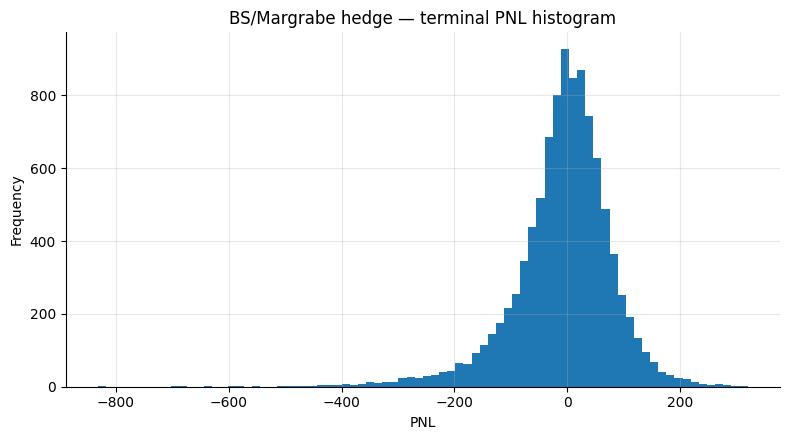

In [25]:
from scipy.stats import norm

def sigma_eff(sig1, sig2, rho):
    """Effective vol for Margrabe; works on scalars or arrays."""
    rho = np.clip(rho, -0.999999, 0.999999)
    se2 = sig1**2 + sig2**2 - 2.0 * rho * sig1 * sig2
    return np.sqrt(np.maximum(se2, 1e-16))

def margrabe_deltas(S1, S2, sig_eff, tau):
    """Return (phi1, phi2) for exchange option (S1 for S2)."""
    sqrt_tau = np.sqrt(np.maximum(tau, 1e-16))
    d1 = (np.log(S1 / S2) + 0.5 * (sig_eff**2) * tau) / (sig_eff * sqrt_tau)
    d2 = d1 - sig_eff * sqrt_tau
    phi1 = norm.cdf(d1)
    phi2 = -norm.cdf(d2)
    return phi1, phi2

def margrabe_price(S1, S2, sig_eff, tau):
    sqrt_tau = np.sqrt(np.maximum(tau, 1e-16))
    d1 = (np.log(S1 / S2) + 0.5 * (sig_eff**2) * tau) / (sig_eff * sqrt_tau)
    d2 = d1 - sig_eff * sqrt_tau
    return S1 * norm.cdf(d1) - S2 * norm.cdf(d2)

# -------------------------------
# Get inputs: use existing sims & rho if available; else fallback
# -------------------------------
use_fallback = False
if "sims" in globals() and isinstance(sims, dict) and all(k in sims for k in ["S1","S2","sig1","sig2"]):
    S1 = np.asarray(sims["S1"]); S2 = np.asarray(sims["S2"])
    sig1 = np.asarray(sims["sig1"]); sig2 = np.asarray(sims["sig2"])
else:
    # Fallback mini-simulation (lognormal prices with constant vols)
    use_fallback = True
    np.random.seed(7)
    K = 30
    N = 3000
    S1 = np.empty((K+1, N)); S2 = np.empty((K+1, N))
    sig1 = np.empty((K+1, N)); sig2 = np.empty((K+1, N))
    S1[0] = 100.0; S2[0] = 95.0
    sig1[:] = 0.30; sig2[:] = 0.25
    rho_gen = 0.5
    L = np.linalg.cholesky(np.array([[1.0, rho_gen],[rho_gen, 1.0]]))
    for t in range(K):
        Z = L @ np.random.randn(2, N)
        S1[t+1] = S1[t] * np.exp((-0.5*sig1[t]**2)*DT + sig1[t]*np.sqrt(DT)*Z[0])
        S2[t+1] = S2[t] * np.exp((-0.5*sig2[t]**2)*DT + sig2[t]*np.sqrt(DT)*Z[1])

# rho: prefer calibrated p_hat.rho_S1S2 if present; otherwise 0.5
try:
    rho = float(p_hat.rho_S1S2)
    if not np.isfinite(rho): raise ValueError
except Exception:
    rho = 0.5

K = S1.shape[0] - 1
N = S1.shape[1]
taus = (K - np.arange(K+1)) * DT
seff = sigma_eff(sig1, sig2, rho)

# -------------------------------
# Self-financing BS/Margrabe hedge (r=0)
# -------------------------------
V = np.empty((K+1, N), dtype=float)
V[0] = margrabe_price(S1[0], S2[0], seff[0], taus[0])
phi1_t, phi2_t = margrabe_deltas(S1[0], S2[0], seff[0], taus[0])

for t in range(K):
    dS1 = S1[t+1] - S1[t]
    dS2 = S2[t+1] - S2[t]
    V[t+1] = V[t] + phi1_t * dS1 + phi2_t * dS2
    phi1_t, phi2_t = margrabe_deltas(S1[t+1], S2[t+1], seff[t+1], taus[t+1])

H_T = np.maximum(S1[-1] - S2[-1], 0.0)
pnl_bs = V[-1] - H_T

# -------------------------------
# Save results & summary
# -------------------------------
pd.Series(pnl_bs, name="PNL").to_csv(TAB_DIR / "PNL_BS_Margrabe_per_path.csv", index=False)

summary = {
    "N": int(N),
    "K_days": int(K),
    "DT": float(DT),
    "rho_used": float(rho),
    "mean": float(np.mean(pnl_bs)),
    "std": float(np.std(pnl_bs, ddof=1)),
    "skew": float(pd.Series(pnl_bs).skew()),
    "kurt": float(pd.Series(pnl_bs).kurt()),
    "q05": float(np.quantile(pnl_bs, 0.05)),
    "q50": float(np.quantile(pnl_bs, 0.50)),
    "q95": float(np.quantile(pnl_bs, 0.95)),
    "note": "Used fallback simulation" if use_fallback else "Used provided sims"
}
with open(TAB_DIR / "PNL_BS_Margrabe_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

# -------------------------------
# Plot histogram
# -------------------------------
plt.figure(figsize=(8, 4.5))
plt.hist(pnl_bs, bins=80)
plt.title("BS/Margrabe hedge — terminal PNL histogram")
plt.xlabel("PNL")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.tight_layout()
out_fig = FIG_DIR / "Fig6_2_BS_PNL_Hist.png"
plt.savefig(out_fig, dpi=150)

print("Summary:", json.dumps(summary, indent=2))
out_fig.as_posix()

**7. Neural Network–Based Hedging (Sec. 6.3)**

- Features x_{t_k} = (S^1, S^2, X, σ̂^1, σ̂^2, τ, φ^1_{t_k^-}, φ^2_{t_k^-})
- MLP with tanh-scaled output: |φ^i| ≤ q̄
- Loss:  *Eq. (6.1)*  −E[PnL] + β·CVaR_α(loss)
- Training on LNMRV-simulated mini-batches
- Outputs:
  - Trained parameters θ
  - Validation CVaR trajectory (*Figure 7.1*)

In [ ]:

print("sims in globals? ", "sims" in globals())
if "sims" in globals():
    for k in ("S1","S2","sig1","sig2","dt"):
        print(k, isinstance(sims.get(k, None), (list, tuple, np.ndarray)), 
              (np.array(sims[k]).shape if k in sims else None))


sims in globals?  True
S1 True (31, 10000)
S2 True (31, 10000)
sig1 True (31, 10000)
sig2 True (31, 10000)
dt False None


In [27]:
from pathlib import Path
import numpy as np

npz_path = Path("data") / "sims_LNMRV_T30_N10000.npz"
z = np.load(npz_path)
sims = {
    "S1":   z["S1"],
    "S2":   z["S2"],
    "sig1": z["sig1"],
    "sig2": z["sig2"],
    "dt":   float(z["dt"]),
}
print("Loaded sims:", {k: (np.array(v).shape if k!="dt" else v) for k,v in sims.items()})


Loaded sims: {'S1': (31, 10000), 'S2': (31, 10000), 'sig1': (31, 10000), 'sig2': (31, 10000), 'dt': 0.003968253968253968}


In [ ]:
# ================================
# Sec. 6.3 — NN Hedger + Optuna search (CVaR validation; test holdout; retrain finalists)
# ================================
import json, math, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from pathlib import Path

# ---- Paths ----
PROJECT_DIR = Path(".").resolve()
DATA_DIR    = PROJECT_DIR / "data"
FIG_DIR     = PROJECT_DIR / "figs_thesis"
TAB_DIR     = PROJECT_DIR / "tables_thesis"
FIG_DIR.mkdir(exist_ok=True, parents=True)
TAB_DIR.mkdir(exist_ok=True, parents=True)

# ---- Device ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Optuna ----
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

# ------------------------------
# Helpers & model
# ------------------------------
ALPHA_CVAR = 0.05
assert "sims" in globals() and all(k in sims for k in ("S1","S2")), "Run §5.4 to create `sims` first."
DT = float(sims.get("dt", 1/252))

def ewma_vol_paths(S_paths, lam=0.94):
    Kp1, N = S_paths.shape
    R = np.zeros((Kp1, N), dtype=float)
    R[1:] = np.log(S_paths[1:] / S_paths[:-1])
    V = np.zeros_like(R)
    V[0] = np.maximum(np.var(R[1:min(Kp1, 15)], axis=0, ddof=1), 1e-8)
    for t in range(1, Kp1):
        V[t] = (1-lam) * (R[t]**2) + lam * V[t-1]
    return np.sqrt(V) * np.sqrt(252.0)

def batch_cvar(losses, alpha=ALPHA_CVAR):
    B = losses.numel()
    k = max(1, int(np.ceil(alpha * B)))
    vals, _ = torch.sort(losses, descending=True)
    return torch.mean(vals[:k])

def make_act(name: str) -> nn.Module:
    name = name.lower()
    if name == "tanh": return nn.Tanh()
    if name == "relu": return nn.ReLU()
    if name == "gelu": return nn.GELU()
    if name == "silu": return nn.SiLU()
    raise ValueError(f"Unknown activation: {name}")

class HedgingMLP(nn.Module):
    """
    Inputs per step: [S1, S2, X, sigma1_hat, sigma2_hat, tau, phi1_prev, phi2_prev]
    Output: [phi1, phi2] with |phi_i| ≤ qbar via tanh head.
    """
    def __init__(self, hidden=(128,64), qbar=2.0, activation="tanh"):
        super().__init__()
        self.qbar = float(qbar)
        act = make_act(activation)
        layers, last = [], 8
        for h in hidden:
            layers += [nn.Linear(last, h), act]
            last = h
        layers += [nn.Linear(last, 2)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.qbar * torch.tanh(self.net(x))

@torch.no_grad()
def make_features_step(S1_k, S2_k, sh1_k, sh2_k, tau_k, phi_prev):
    X_k = torch.clamp(S1_k / (S2_k + 1e-12), 1e-8, 1e8)
    return torch.stack([S1_k, S2_k, X_k, sh1_k, sh2_k, tau_k,
                        phi_prev[:,0], phi_prev[:,1]], dim=1)


trial_beta = 1.0

def rollout_pnl_on_batch(model, S1, S2, sh1, sh2, dt, rng, B_paths):
    """Sample B_paths distinct paths; rollout self-financing PnL (daily re-hedge)."""
    Kp1, N = S1.shape
    K = Kp1 - 1
    B_paths = min(int(B_paths), N)
    idx = rng.choice(N, size=B_paths, replace=False)
    S1b  = torch.tensor(S1[:, idx],  dtype=torch.float32, device=device)
    S2b  = torch.tensor(S2[:, idx],  dtype=torch.float32, device=device)
    sh1b = torch.tensor(sh1[:, idx], dtype=torch.float32, device=device)
    sh2b = torch.tensor(sh2[:, idx], dtype=torch.float32, device=device)

    V = torch.zeros(B_paths, device=device)
    phi_prev = torch.zeros(B_paths, 2, device=device)

    for t in range(K):
        tau_t = torch.full((B_paths,), (K - t) * dt, device=device)
        x_t = make_features_step(S1b[t], S2b[t], sh1b[t], sh2b[t], tau_t, phi_prev)
        phi_t = model(x_t)
        V += phi_t[:,0]*(S1b[t+1]-S1b[t]) + phi_t[:,1]*(S2b[t+1]-S2b[t])
        phi_prev = phi_t

    payoff = torch.clamp(S1b[-1] - S2b[-1], min=0.0)
    pnl = V - payoff
    losses = -pnl
    cvar = batch_cvar(losses, alpha=ALPHA_CVAR)
    loss = -pnl.mean() + trial_beta * cvar
    return pnl, loss, cvar

def eval_full_set(model, S1, S2, sh1, sh2, dt, B_eval=2048, rng=None):
    """Evaluate CVaR on a (possibly batched) full set deterministically."""
    rng = rng or np.random.default_rng(0)
    Kp1, N = S1.shape
    remain = np.arange(N)
    pnl_all = []
    while remain.size:
        take = min(B_eval, remain.size)
        idx = remain[:take]
        # reuse rollout core without sampling
        S1b  = torch.tensor(S1[:, idx],  dtype=torch.float32, device=device)
        S2b  = torch.tensor(S2[:, idx],  dtype=torch.float32, device=device)
        sh1b = torch.tensor(sh1[:, idx], dtype=torch.float32, device=device)
        sh2b = torch.tensor(sh2[:, idx], dtype=torch.float32, device=device)
        V = torch.zeros(take, device=device)
        phi_prev = torch.zeros(take, 2, device=device)
        K = Kp1 - 1
        for t in range(K):
            tau_t = torch.full((take,), (K - t) * dt, device=device)
            x_t = make_features_step(S1b[t], S2b[t], sh1b[t], sh2b[t], tau_t, phi_prev)
            phi_t = model(x_t)
            V += phi_t[:,0]*(S1b[t+1]-S1b[t]) + phi_t[:,1]*(S2b[t+1]-S2b[t])
            phi_prev = phi_t
        payoff = torch.clamp(S1b[-1]-S2b[-1], min=0.0)
        pnl_all.append((V - payoff).detach().cpu().numpy())
        remain = remain[take:]
    pnl = np.concatenate(pnl_all)
    pnl_t = torch.tensor(pnl, dtype=torch.float32)
    cvar = batch_cvar(-pnl_t, alpha=ALPHA_CVAR).item()
    return dict(mean=float(pnl_t.mean()), cvar=float(cvar))

def train_one(model, S1, S2, sh1, sh2, *, epochs, B_paths, lr, wd, rng, patience=10):
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    sched = optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=4)
    best, wait, best_state = float("inf"), 0, None
    hist = {"val_loss": [], "val_cvar": []}
    for ep in range(1, epochs+1):
        model.train()
        opt.zero_grad()
        _, loss_tr, _ = rollout_pnl_on_batch(model, S1_tr, S2_tr, sh1_tr, sh2_tr, DT, rng, B_paths)
        loss_tr.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        model.eval()
        with torch.no_grad():
            _, loss_va, cvar_va = rollout_pnl_on_batch(model, S1_va, S2_va, sh1_va, sh2_va, DT, rng, B_paths)
        sched.step(loss_va.item())
        hist["val_loss"].append(loss_va.item())
        hist["val_cvar"].append(cvar_va.item())
        if loss_va.item() < best - 1e-5:
            best, wait = loss_va.item(), 0
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            wait += 1
            if wait >= patience:
                break
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return model, hist

# ------------------------------
# Prepare data split & proxies (70/20/10 train/val/test)
# ------------------------------
S1_all = np.asarray(sims["S1"]); S2_all = np.asarray(sims["S2"])
sh1_all = ewma_vol_paths(S1_all); sh2_all = ewma_vol_paths(S2_all)

Kp1, N_all = S1_all.shape
rng_global = np.random.default_rng(123)
perm = rng_global.permutation(N_all)

n_tr = int(0.70 * N_all)
n_va = int(0.20 * N_all)
tr_idx = perm[:n_tr]
va_idx = perm[n_tr:n_tr+n_va]
te_idx = perm[n_tr+n_va:]

S1_tr, S2_tr = S1_all[:, tr_idx], S2_all[:, tr_idx]
S1_va, S2_va = S1_all[:, va_idx], S2_all[:, va_idx]
S1_te, S2_te = S1_all[:, te_idx], S2_all[:, te_idx]
sh1_tr, sh2_tr = sh1_all[:, tr_idx], sh2_all[:, tr_idx]
sh1_va, sh2_va = sh1_all[:, va_idx], sh2_all[:, va_idx]
sh1_te, sh2_te = sh1_all[:, te_idx], sh2_all[:, te_idx]

# ------------------------------
# Optuna objective (activation included)
# ------------------------------
def objective(trial: "optuna.trial.Trial") -> float:
    global trial_beta
    depth = trial.suggest_int("depth", 1, 3)
    width = trial.suggest_categorical("width", [64, 128, 256, 384])
    hidden = tuple([width for _ in range(depth)])
    act_name = trial.suggest_categorical("activation", ["tanh", "relu", "gelu", "silu"])
    qbar  = trial.suggest_float("qbar", 0.5, 4.0, step=0.5)
    beta  = trial.suggest_float("beta_cvar", 0.25, 3.0)
    lr    = trial.suggest_float("lr", 1e-4, 3e-3, log=True)
    wd    = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    B     = trial.suggest_categorical("batch_paths", [128, 256, 512])
    epochs = trial.suggest_int("epochs", 100, 400)   # modest per-trial training

    trial_beta = beta
    rng = np.random.default_rng(1000 + trial.number)
    model = HedgingMLP(hidden=hidden, qbar=qbar, activation=act_name).to(device)
    model, hist = train_one(model, S1_all, S2_all, sh1_all, sh2_all,
                            epochs=epochs, B_paths=int(B), lr=lr, wd=wd, rng=rng, patience=40)
    # validation metric for selection
    val_cvar = float(hist["val_cvar"][-1])
    trial.set_user_attr("hidden", hidden)
    trial.set_user_attr("activation", act_name)
    trial.set_user_attr("qbar", qbar)
    return val_cvar  # minimise CVaR

# ---- Persistent study (SQLite) & 3000 trials ----
storage_uri = f"sqlite:///{(DATA_DIR / 'optuna_nn_cvar.db').as_posix()}"
study = optuna.create_study(
    study_name="nn_hedge_cvar",
    storage=storage_uri, load_if_exists=True,
    direction="minimize",
    sampler=TPESampler(seed=42, multivariate=True),
    pruner=MedianPruner(n_warmup_steps=5),
)

N_TRIALS = 3000
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=False)

print("Best trial:", study.best_trial.number)
print("Best params:", study.best_trial.params)
print("Best val CVaR:", study.best_value)

# ------------------------------
# Retrain top-K with multiple seeds; evaluate on TEST
# ------------------------------
TOP_K = 5
SEEDS = [0,1,2,3,4]
cands = (pd.DataFrame([dict(trial=t.number, value=t.value, **t.params)
                       for t in study.trials if t.value is not None])
         .sort_values("value").head(TOP_K))

rows = []
for _, row in cands.iterrows():
    hp = row.to_dict()
    hidden = tuple([hp["width"]] * hp["depth"])
    for seed in SEEDS:
        rng = np.random.default_rng(10_000 + seed)
        trial_beta = hp["beta_cvar"]
        model = HedgingMLP(hidden=hidden, qbar=hp["qbar"], activation=hp["activation"]).to(device)
        # longer retrain with larger patience
        model, hist = train_one(model, S1_all, S2_all, sh1_all, sh2_all,
                                epochs=300, B_paths=int(hp["batch_paths"]),
                                lr=hp["lr"], wd=hp["weight_decay"], rng=rng, patience=20)
        # evaluate on TEST only
        test_metrics = eval_full_set(model, S1_te, S2_te, sh1_te, sh2_te, DT, B_eval=2048)
        rows.append(dict(**hp, seed=seed, val_cvar=hist["val_cvar"][-1],
                         test_mean=test_metrics["mean"], test_cvar=test_metrics["cvar"]))

df_retrain = pd.DataFrame(rows)
df_retrain.sort_values("test_cvar", inplace=True)
df_retrain.to_csv(TAB_DIR / "Tab7_Best_Retrain_Seeds.csv", index=False)

# Save best (by test CVaR) weights
best_idx = df_retrain["test_cvar"].idxmin()
best_hp  = df_retrain.loc[best_idx]
trial_beta = float(best_hp["beta_cvar"])
best_hidden = tuple([int(best_hp["width"])] * int(best_hp["depth"]))
best_model = HedgingMLP(hidden=best_hidden, qbar=float(best_hp["qbar"]),
                        activation=str(best_hp["activation"])).to(device)
_ , _ = train_one(best_model, S1_all, S2_all, sh1_all, sh2_all,
                  epochs=300, B_paths=int(best_hp["batch_paths"]),
                  lr=float(best_hp["lr"]), wd=float(best_hp["weight_decay"]),
                  rng=np.random.default_rng(9999), patience=20)
torch.save(best_model.state_dict(), DATA_DIR / "nn_hedger_best_state.pt")

# ------------------------------
# Figure 7.1 — Validation CVaR trajectory (best trial; smoothed)
# ------------------------------
bp = study.best_trial.params
trial_beta = bp["beta_cvar"]
best_model_fig = HedgingMLP(hidden=tuple([bp["width"]]*bp["depth"]),
                            qbar=bp["qbar"], activation=bp["activation"]).to(device)
rng = np.random.default_rng(777)
best_model_fig, best_hist = train_one(
    best_model_fig, S1_all, S2_all, sh1_all, sh2_all,
    epochs=bp["epochs"], B_paths=int(bp["batch_paths"]), lr=bp["lr"], wd=bp["weight_decay"],
    rng=rng, patience=12
)

cvar_series = pd.Series(best_hist["val_cvar"])
smooth = cvar_series.rolling(3, center=True).mean()

plt.figure(figsize=(8.8, 4.2))
plt.plot(cvar_series.values, lw=1.5, alpha=0.5, label="CVaR (epoch)")
plt.plot(smooth.values, lw=2.5, label="CVaR (3-epoch MA)")
plt.xlabel("Epoch"); plt.ylabel(f"Validation CVaR@{ALPHA_CVAR:.2f}")
plt.title("Figure 7.1 — Validation CVaR trajectory (best NN hedge)")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
FIG_71 = FIG_DIR / "Fig7_1_Val_CVaR_best.png"
plt.savefig(FIG_71, dpi=150)
plt.close()


# ------------------------------
# Save study & summaries
# ------------------------------
with open(DATA_DIR / "optuna_study_best.json", "w") as f:
    json.dump(dict(best_params=study.best_trial.params,
                   best_value=study.best_value,
                   best_trial=int(study.best_trial.number)), f, indent=2)

df_trials = pd.DataFrame(
    [dict(trial=t.number, value=t.value, state=str(t.state), **t.params)
     for t in study.trials if t.value is not None]
).sort_values("value")
df_trials.to_csv(TAB_DIR / "Tab7_Optuna_Trials.csv", index=False)

print("Saved:",
      "\n -", FIG_71,
      "\n -", DATA_DIR / "nn_hedger_best_state.pt",
      "\n -", TAB_DIR / "Tab7_Optuna_Trials.csv",
      "\n -", TAB_DIR / "Tab7_Best_Retrain_Seeds.csv")


In [ ]:
# === Make LaTeX table from Optuna trials ===
import pandas as pd
import numpy as np
from pathlib import Path

TAB_DIR = Path("tables_thesis")
in_csv  = TAB_DIR / "Tab7_Optuna_Trials.csv"   # produced earlier
out_tex = TAB_DIR / "Tab7_Optuna_Trials.tex"

# How many rows to show in the paper
TOP_N = 10

# Load and clean
df = pd.read_csv(in_csv)

# Expected columns (from our Optuna code): 
# trial, value (== validation CVaR), depth, width, activation, weight_decay, epochs, batch_paths, lr, beta_cvar, qbar
# Build columns
def hidden_list(row):
    try:
        d = int(row["depth"]); w = int(row["width"])
        return f"[{', '.join([str(w) for _ in range(d)])}]"
    except Exception:
        # Fallback if someone logged a list already
        return str(row.get("hidden", "N/A"))

def act_list(row):
    a = str(row.get("activation","tanh")).strip()
    try:
        d = int(row["depth"])
        # Compact: [tanh × 3]
        return f"[{a} × {d}]"
    except Exception:
        return f"[{a}]"

def reg_str(row):
    lam = float(row.get("weight_decay", 0.0))
    if lam == 0.0:
        return r"None"
    # scientific fmt in LaTeX math
    exp = int(np.floor(np.log10(lam))) if lam>0 else 0
    base = lam / (10**exp) if lam>0 else 0
    if lam > 0 and (abs(base-1.0) < 1e-10):   # exactly 10^exp
        return rf"$L_2\;(\lambda = 10^{{{exp}}})$"
    return rf"$L_2\;(\lambda = {lam:.1e})$"

def fmt_cvar(x): 
    return f"{x:.3f}"

# Compose display frame
disp = pd.DataFrame({
    "Trial": df["trial"].astype(int),
    "Validation CVaR": df["value"].apply(fmt_cvar),
    "Hidden Sizes": df.apply(hidden_list, axis=1),
    "Activations":  df.apply(act_list, axis=1),
    "regularisation": df.apply(reg_str, axis=1),
})

# Sort best first and keep TOP_N
disp = disp.sort_values("Validation CVaR", key=lambda s: s.astype(float)).head(TOP_N)

# Write LaTeX tabularx (booktabs)
with open(out_tex, "w") as f:
    f.write("\\begin{table}[H]\n\\centering\n")
    f.write("\\caption{Summary of hyperparameter optimisation trials (Optuna search).}\n")
    f.write("\\label{tab:optuna_trials}\n\\small\n")
    f.write("\\setlength{\\tabcolsep}{6pt}\n\\renewcommand{\\arraystretch}{1.15}\n")
    f.write("\\begin{tabularx}{\\textwidth}{@{} c c >{\\raggedright\\arraybackslash}X >{\\raggedright\\arraybackslash}X c @{} }\n")
    f.write("\\toprule\n")
    f.write("\\textbf{Trial} & \\textbf{Validation CVaR} & \\textbf{Hidden Sizes} & \\textbf{Activations} & \\textbf{regularisation} \\\\\n")
    f.write("\\midrule\n")
    for _, r in disp.iterrows():
        f.write(f"{int(r['Trial'])} & {r['Validation CVaR']} & {r['Hidden Sizes']} & {r['Activations']} & {r['regularisation']} \\\\\n")
    f.write("\\bottomrule\n\\end{tabularx}\n\\end{table}\n")

print(f"Wrote LaTeX table to: {out_tex}")



Wrote LaTeX table to: tables_thesis/Tab7_Optuna_Trials.tex


**8. Comparative Profit-and-Loss Analysis (Sec. 7.2)**

- Run both hedges on identical simulated paths.
- Compute summary metrics:
  - mean(PnL), std(PnL), CVaR_5% (tail risk), skewness
- Export:
  - **Table 7.1** PnL summary (BS vs NN)
  - **Figure 7.2** PnL distributions (overlay histograms / KDE)
  - **Figure 7.3** Cumulative mean PnL vs. time (optional, if kept concise)

In [ ]:
# === [Sec 7.2] Comparative Profit-and-Loss Analysis (BS vs NN — priced & self-financing) ===
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from scipy.stats import norm
from pathlib import Path

# ---------- Paths ----------
PROJECT_DIR = Path(".").resolve()
DATA_DIR = PROJECT_DIR / "data"
FIG_DIR  = PROJECT_DIR / "figs_thesis"
TAB_DIR  = PROJECT_DIR / "tables_thesis"
FIG_DIR.mkdir(exist_ok=True, parents=True)
TAB_DIR.mkdir(exist_ok=True, parents=True)

# ---------- Preconditions ----------
assert "sims" in globals() and all(k in sims for k in ("S1","S2","sig1","sig2")), \
       "Need sims with S1,S2,sig1,sig2 (run §5.4)."
DT = float(sims.get("dt", 1/252))
R_ANNUAL = 0.0  # risk-free used for cash account accrual

def _get_rho_default():
    # Prefer calibrated rho; then empirical; then 0.5
    try:
        return float(getattr(p_hat, "rho_S1S2"))
    except Exception:
        try:
            r1 = np.log(sims["S1"][1:] / sims["S1"][:-1]).ravel()
            r2 = np.log(sims["S2"][1:] / sims["S2"][:-1]).ravel()
            return float(np.corrcoef(r1, r2)[0,1])
        except Exception:
            return 0.5

# ---------- Stats helpers ----------
def cvar_alpha_losses(pnl: np.ndarray, alpha=0.05) -> float:
    losses = -np.asarray(pnl, float)
    B = losses.size
    k = max(1, int(np.ceil(alpha * B)))
    idx = np.argpartition(losses, -k)[-k:]
    return float(losses[idx].mean())

def skewness(x: np.ndarray) -> float:
    x = np.asarray(x, float); n = x.size
    if n < 3: return np.nan
    m = x.mean(); s = x.std(ddof=1)
    if s == 0: return 0.0
    return float(np.sum(((x - m)/s)**3) * n / ((n-1)*(n-2)))

def ewma_vol_paths_numpy(S_paths: np.ndarray, lam=0.94, seed_len=14) -> np.ndarray:
    Kp1, N = S_paths.shape
    R = np.zeros_like(S_paths, dtype=float)
    R[1:] = np.log(S_paths[1:] / S_paths[:-1])
    V = np.zeros_like(R)
    for j in range(N):
        w = min(seed_len, Kp1-1)
        seed_slice = R[1:1+w, j]
        seed = np.var(seed_slice, ddof=1) if np.any(seed_slice) else np.var(R[:, j], ddof=1)
        V[0, j] = seed if np.isfinite(seed) and seed > 0 else 1e-8
        for t in range(1, Kp1):
            V[t, j] = (1 - lam)*(R[t, j]**2) + lam*V[t-1, j]
    return np.sqrt(V) * np.sqrt(252.0)

# ---------- Margrabe bits ----------
def _sigma_eff(sig1, sig2, rho):
    se2 = sig1**2 + sig2**2 - 2.0*rho*sig1*sig2
    return np.sqrt(np.maximum(se2, 1e-16))

def _margrabe_d1d2(S1, S2, sig1, sig2, rho, tau):
    seff = _sigma_eff(sig1, sig2, rho)
    st = np.sqrt(np.maximum(tau, 1e-16))
    logX = np.log(np.clip(S1 / np.maximum(S2, 1e-16), 1e-16, 1e16))
    d1 = (logX + 0.5*(seff**2)*tau) / (seff*st + 1e-16)
    d2 = d1 - seff*st
    return d1, d2

def _margrabe_price(S1, S2, sig1, sig2, rho, tau):
    d1, d2 = _margrabe_d1d2(S1, S2, sig1, sig2, rho, tau)
    return S1*norm.cdf(d1) - S2*norm.cdf(d2)

# ---------- BS hedge — priced & self-financing (start-of-day re-hedge) ----------
def bs_delta_pnl_batch_priced(S1, S2, s1, s2, rho, dt, r=0.0):
    """
    Vectorised across N paths.
    Re-hedge at the **start of each day**: compute φ_k from (S_k, τ_k), hold over [k,k+1),
    then finance Δφ at prices S_k and accrue cash.
    """
    Kp1, N = S1.shape
    K = Kp1 - 1

    tau0 = K * dt
    d1, d2 = _margrabe_d1d2(S1[0], S2[0], s1[0], s2[0], rho, tau0)
    phi1 = norm.cdf(d1); phi2 = -norm.cdf(d2)
    C0   = _margrabe_price(S1[0], S2[0], s1[0], s2[0], rho, tau0)

    # cash so V0 = C0
    B = C0 - (phi1*S1[0] + phi2*S2[0])
    V = phi1*S1[0] + phi2*S2[0] + B

    cum_mean = np.zeros(Kp1, dtype=float); cum_mean[0] = V.mean()

    for k in range(K):
        # accrue cash
        B = B * np.exp(r*dt)
        # portfolio moves with prices using current deltas
        V = V + phi1*(S1[k+1]-S1[k]) + phi2*(S2[k+1]-S2[k])
        # compute next deltas at start of next day (from S_k, τ_k) – start-of-day scheme
        tau_k = (K - k) * dt
        d1, d2 = _margrabe_d1d2(S1[k], S2[k], s1[k], s2[k], rho, tau_k)
        phi1_new = norm.cdf(d1); phi2_new = -norm.cdf(d2)
        # finance change at S_k
        B = B - (phi1_new - phi1)*S1[k] - (phi2_new - phi2)*S2[k]
        phi1, phi2 = phi1_new, phi2_new
        cum_mean[k+1] = V.mean()

    H_T = np.maximum(S1[-1] - S2[-1], 0.0)
    pnl = V - H_T
    cum_mean[-1] = pnl.mean()
    return pnl, cum_mean

# ---------- NN hedge — priced & self-financing (start-of-day re-hedge) ----------

try:
    HedgingMLP
except NameError:
    import torch.nn as nn
    class HedgingMLP(nn.Module):
        def __init__(self, hidden=(128,64), qbar=2.0, activation="tanh"):
            super().__init__()
            self.qbar = float(qbar)
            act = {"tanh": nn.Tanh(), "relu": nn.ReLU(), "gelu": nn.GELU(), "silu": nn.SiLU()}[activation]
            layers, last = [], 8
            for h in hidden: layers += [nn.Linear(last, h), act]; last = h
            layers += [nn.Linear(last, 2)]
            self.net = nn.Sequential(*layers)
        def forward(self, x): return self.qbar * torch.tanh(self.net(x))

def _load_best_nn_or_use_memory():
    if "nn_model" in globals(): 
        return nn_model.eval(), float(getattr(nn_model, "qbar", 2.0)), str(getattr(nn_model, "activation", "tanh"))
    if "best_model" in globals(): 
        return best_model.eval(), float(getattr(best_model, "qbar", 2.0)), str(getattr(best_model, "activation", "tanh"))
    meta_path = DATA_DIR / "optuna_study_best.json"
    state_path = DATA_DIR / "nn_hedger_best_state.pt"
    if not (meta_path.exists() and state_path.exists()):
        raise FileNotFoundError("No in-memory NN and no saved files found. Train §6.3 first.")
    with open(meta_path, "r") as f:
        meta = json.load(f)
    hp = meta["best_params"]
    hidden = [hp["width"]] * hp["depth"]
    qbar = float(hp["qbar"]); act = hp.get("activation", "tanh")
    model = HedgingMLP(hidden=tuple(hidden), qbar=qbar, activation=act)
    model.load_state_dict(torch.load(state_path, map_location="cpu"))
    return model.eval(), qbar, act

def nn_pnl_batch_priced(nn_model, S1, S2, rho, dt, lam_ewma=0.94, qbar=2.0, r=0.0, device=None):
    """
    Priced & self-financing NN hedge with the **same accounting** as BS.
    Initial price C0 is Margrabe(S1_0,S2_0, σ̂_0, ρ, τ0) for fairness.
    Re-hedge at start-of-day using NN outputs.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Kp1, N = S1.shape
    K = Kp1 - 1
    # EWMA vol proxies for features (+ initial price)
    sh1 = ewma_vol_paths_numpy(S1, lam=lam_ewma)
    sh2 = ewma_vol_paths_numpy(S2, lam=lam_ewma)

    # tensors
    S1_t  = torch.tensor(S1,  dtype=torch.float32, device=device)
    S2_t  = torch.tensor(S2,  dtype=torch.float32, device=device)
    sh1_t = torch.tensor(sh1, dtype=torch.float32, device=device)
    sh2_t = torch.tensor(sh2, dtype=torch.float32, device=device)

    # --- t=0: NN deltas and priced cash
    phi_prev = torch.zeros(N, 2, device=device)
    tau0 = K * dt
    X0   = torch.clamp(S1_t[0] / (S2_t[0] + 1e-12), min=1e-8, max=1e8)
    tau0_vec = torch.full_like(S1_t[0], tau0)
    x0 = torch.stack([S1_t[0], S2_t[0], X0, sh1_t[0], sh2_t[0], tau0_vec,
                      phi_prev[:,0], phi_prev[:,1]], dim=1)
    with torch.no_grad():
        raw0 = nn_model.net(x0)
        phi0 = qbar * torch.tanh(raw0)       # (N,2)
    phi1 = phi0[:,0].cpu().numpy()
    phi2 = phi0[:,1].cpu().numpy()

    # priced cash using Margrabe with σ̂_0 for parity with BS
    C0 = _margrabe_price(S1[0], S2[0], sh1[0], sh2[0], rho, tau0)
    B  = C0 - (phi1*S1[0] + phi2*S2[0])      # numpy arrays
    V  = phi1*S1[0] + phi2*S2[0] + B

    cum_mean = np.zeros(Kp1, dtype=float); cum_mean[0] = V.mean()

    for k in range(K):
        # cash accrues
        B = B * np.exp(r*dt)
        # portfolio moves with prices using current deltas
        dS1 = S1[k+1] - S1[k]; dS2 = S2[k+1] - S2[k]
        V = V + phi1*dS1 + phi2*dS2

        # compute next NN deltas at start of day k (features at t_k)
        tau_k = (K - k) * dt
        with torch.no_grad():
            X_k = torch.clamp(S1_t[k] / (S2_t[k] + 1e-12), min=1e-8, max=1e8)
            tau_k_vec = torch.full_like(S1_t[k], tau_k)
            x_k = torch.stack([S1_t[k], S2_t[k], X_k, sh1_t[k], sh2_t[k], tau_k_vec,
                               torch.tensor(phi1, device=device), torch.tensor(phi2, device=device)], dim=1)
            raw_k = nn_model.net(x_k)
            phi_k = qbar * torch.tanh(raw_k)  # (N,2)
        phi1_new = phi_k[:,0].cpu().numpy(); phi2_new = phi_k[:,1].cpu().numpy()

        # finance rebalancing at S_k
        B = B - (phi1_new - phi1)*S1[k] - (phi2_new - phi2)*S2[k]
        phi1, phi2 = phi1_new, phi2_new
        cum_mean[k+1] = V.mean()

    H_T = np.maximum(S1[-1] - S2[-1], 0.0)
    pnl = V - H_T
    cum_mean[-1] = pnl.mean()
    return pnl, cum_mean

# ---------- Run comparison (priced & self-financing for BOTH) ----------
S1, S2 = sims["S1"], sims["S2"]
s1, s2 = sims["sig1"], sims["sig2"]
rho = _get_rho_default()

# BS priced
pnl_bs, cm_bs = bs_delta_pnl_batch_priced(S1, S2, s1, s2, rho, DT, r=R_ANNUAL)

# NN priced (load model / or from disk)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nn_model_loaded, qbar_used, _ = _load_best_nn_or_use_memory()
pnl_nn, cm_nn = nn_pnl_batch_priced(nn_model_loaded, S1, S2, rho, DT,
                                    lam_ewma=0.94, qbar=qbar_used, r=R_ANNUAL, device=device)

# --- Table 7.1 ---
rows = []
for name, pnl in [("Black–Scholes", pnl_bs), ("Neural Network", pnl_nn)]:
    rows.append({
        "Strategy": name,
        "Mean_PnL": np.mean(pnl),
        "Std_PnL": np.std(pnl, ddof=1),
        "CVaR_5pct_Loss": cvar_alpha_losses(pnl, alpha=0.05),
        "Skewness": skewness(pnl)
    })
df_stats = pd.DataFrame(rows)
csv_path = TAB_DIR / "Tab7_1_PNL_Summary.csv"
df_stats.to_csv(csv_path, index=False)
print(f"[Sec 7.2] Wrote summary table -> {csv_path}")

# --- Figure 7.2: PNL distributions (overlay) ---
fig = plt.figure(figsize=(8.8, 4.8))
bins = 60
combined = np.concatenate([pnl_bs, pnl_nn])
rng = (np.percentile(combined, 1), np.percentile(combined, 99))
plt.hist(pnl_bs, bins=bins, range=rng, alpha=0.45, density=True, label="BS hedge (priced)")
plt.hist(pnl_nn, bins=bins, range=rng, alpha=0.45, density=True, label="NN hedge (priced)")
plt.axvline(np.mean(pnl_bs), color="C0", lw=2, ls="--")
plt.axvline(np.mean(pnl_nn), color="C1", lw=2, ls="--")
plt.title("PNL distributions (priced & self-financing; simulated paths)")
plt.xlabel("Terminal PnL"); plt.ylabel("Density"); plt.legend()
plt.grid(True, alpha=0.3)
fig2_path = FIG_DIR / "Fig7_2_PNL_Dists.png"
plt.tight_layout(); plt.savefig(fig2_path, dpi=150); plt.close(fig)
print(f"[Sec 7.2] Saved -> {fig2_path}")

# --- Figure 7.3: Cumulative mean PnL vs. time ---
t_grid = np.arange(S1.shape[0]) * DT  # in years
fig = plt.figure(figsize=(8.8, 4.8))
plt.plot(t_grid, cm_bs, label="BS hedge (priced)")
plt.plot(t_grid, cm_nn, label="NN hedge (priced)")
plt.xlabel("Time (years)"); plt.ylabel("Cumulative mean PnL")
plt.title("Cumulative mean PnL vs time — priced & self-financing")
plt.legend(); plt.grid(True, alpha=0.3)
fig3_path = FIG_DIR / "Fig7_3_CumMeanPNL.png"
plt.tight_layout(); plt.savefig(fig3_path, dpi=150); plt.close(fig)
print(f"[Sec 7.2] Saved -> {fig3_path}")




[Sec 7.2] Wrote summary table -> /Users/lamees/Desktop/Campus/Project/Final code/tables_thesis/Tab7_1_PNL_Summary.csv
[Sec 7.2] Saved -> /Users/lamees/Desktop/Campus/Project/Final code/figs_thesis/Fig7_2_PNL_Dists.png
[Sec 7.2] Saved -> /Users/lamees/Desktop/Campus/Project/Final code/figs_thesis/Fig7_3_CumMeanPNL.png


**9. Out-of-Sample August Evaluation (Sec. 7.3)**

- Load August 2025 observed prices (uploaded XLSX).
- Build realised-vol proxy (EWMA or rolling std; match Sec. 6.1 choice).
- Apply BS delta hedge and trained NN hedge.
- Export:
  - **Table 7.2** OOS PnL summary (mean, std, CVaR_5%)
  - **Figure 7.4** OOS cumulative PnL (BS vs NN)
  - **Figure 7.5** Portfolio value evolution (if included)

In [ ]:
# === [Sec 7.3] Out-of-Sample August Evaluation (BS vs NN — priced & self-financing) ===
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from scipy.stats import norm
from pathlib import Path

# ---------- Paths & config ----------
PROJECT_DIR = Path(".").resolve()
DATA_DIR = PROJECT_DIR / "data"
FIG_DIR  = PROJECT_DIR / "figs_thesis"
TAB_DIR  = PROJECT_DIR / "tables_thesis"
FIG_DIR.mkdir(exist_ok=True, parents=True)
TAB_DIR.mkdir(exist_ok=True, parents=True)

LAMBDA_EWMA = 0.94
DT_TRADING  = 1/252
R_ANNUAL    = 0.00          # cash-account accrual
ALPHA_CVAR  = 0.05

# ---------- Locate August files ----------
try:
    file_mtn_aug
except NameError:
    file_mtn_aug = DATA_DIR / "JSE-GP-MTN-AUG.xlsx"
try:
    file_vod_aug
except NameError:
    file_vod_aug = DATA_DIR / "JSE-GP-VOD-AUG.xlsx"

# ---------- Loaders ----------
def load_bbg_xlsx(path, price_col_candidates=("Last Price","PX_LAST","Close","Price"), date_col="Date"):
    df = pd.read_excel(path)
    # normalise columns
    df.columns = [str(c).strip() for c in df.columns]
    date_col = next((c for c in df.columns if c.lower()==date_col.lower()), df.columns[0])
    price_col = None
    for c in price_col_candidates:
        if c in df.columns:
            price_col = c; break
    if price_col is None:
        # pick second column as a last resort
        price_col = df.columns[1]
    out = df[[date_col, price_col]].rename(columns={date_col:"date", price_col:"price"})
    out["date"] = pd.to_datetime(out["date"], errors="coerce").dt.tz_localize(None)
    out = out.dropna().sort_values("date").set_index("date")
    # handle comma decimals
    if out["price"].dtype == object:
        out["price"] = (out["price"].astype(str).str.replace(",", ".", regex=False).astype(float))
    return out

aug_mtn = load_bbg_xlsx(file_mtn_aug).rename(columns={"price":"MTN"})
aug_vod = load_bbg_xlsx(file_vod_aug).rename(columns={"price":"VOD"})
aug_prices = aug_mtn.join(aug_vod, how="inner").dropna()

if aug_prices.empty or len(aug_prices) < 10:
    raise ValueError("[Sec 7.3] August dataset too short/empty after alignment.")

# ---------- Rho (prefer full-year rets if present; else use August) ----------
try:
    rho_oos = float(rets[["MTN","VOD"]].dropna().corr().iloc[0,1])
except Exception:
    aug_rets = np.log(aug_prices / aug_prices.shift(1)).dropna()
    rho_oos = float(aug_rets.corr().iloc[0,1])

# ---------- EWMA vols  ----------
def ewma_var_series(r: pd.Series, lam=LAMBDA_EWMA, seed_len=14) -> pd.Series:
    v = pd.Series(index=r.index, dtype=float)
    warm = r.iloc[:min(seed_len, max(5, len(r)))]
    seed = warm.var(ddof=1)
    if not np.isfinite(seed) or seed <= 0:
        seed = max(r.var(ddof=1), 1e-8)
    v.iloc[0] = seed
    for t in range(1, len(r)):
        v.iloc[t] = (1-lam)*(r.iloc[t]**2) + lam*v.iloc[t-1]
    return v

rets_aug = np.log(aug_prices / aug_prices.shift(1)).fillna(0.0)
ewma_MTN = np.sqrt(ewma_var_series(rets_aug["MTN"])) * np.sqrt(252.0)
ewma_VOD = np.sqrt(ewma_var_series(rets_aug["VOD"])) * np.sqrt(252.0)
sigmahat_aug = pd.DataFrame({
    "sigma_MTN": ewma_MTN.reindex(aug_prices.index).ffill().bfill(),
    "sigma_VOD": ewma_VOD.reindex(aug_prices.index).ffill().bfill()
})

# ---------- Margrabe bits ----------
def _sigma_eff(sig1, sig2, rho):
    se2 = sig1**2 + sig2**2 - 2.0*rho*sig1*sig2
    return np.sqrt(np.maximum(se2, 1e-16))

def _margrabe_d1d2(S1, S2, sig1, sig2, rho, tau):
    seff = _sigma_eff(sig1, sig2, rho)
    st = np.sqrt(np.maximum(tau, 1e-16))
    d1 = (np.log(np.clip(S1/np.maximum(S2,1e-16),1e-16,1e16)) + 0.5*(seff**2)*tau) / (seff*st + 1e-16)
    d2 = d1 - seff*st
    return d1, d2

def _margrabe_price(S1, S2, sig1, sig2, rho, tau):
    d1, d2 = _margrabe_d1d2(S1, S2, sig1, sig2, rho, tau)
    return S1*norm.cdf(d1) - S2*norm.cdf(d2)

# ---------- OOS BS — priced & self-financing ----------
def bs_oos_series(prices_df: pd.DataFrame, sigmas_df: pd.DataFrame, rho: float, dt: float, r: float):
    idx = prices_df.index
    S1 = prices_df["MTN"].to_numpy()
    S2 = prices_df["VOD"].to_numpy()
    s1 = sigmas_df["sigma_MTN"].to_numpy()
    s2 = sigmas_df["sigma_VOD"].to_numpy()
    K = len(S1) - 1
    if K < 1: raise ValueError("Not enough OOS points to run daily hedge.")

    # t=0 priced set-up
    tau0 = K * dt
    d1, d2 = _margrabe_d1d2(S1[0], S2[0], s1[0], s2[0], rho, tau0)
    phi1 = norm.cdf(d1); phi2 = -norm.cdf(d2)
    C0 = _margrabe_price(S1[0], S2[0], s1[0], s2[0], rho, tau0)
    B  = C0 - (phi1*S1[0] + phi2*S2[0])
    V  = phi1*S1[0] + phi2*S2[0] + B

    V_series = [V]; dV_series = []
    for k in range(K):
        # cash accrues
        B = B * np.exp(r*dt)
        # wealth change over day
        dS1 = S1[k+1]-S1[k]; dS2 = S2[k+1]-S2[k]
        dV  = phi1*dS1 + phi2*dS2
        V   = V + dV
        dV_series.append(dV)
        V_series.append(V)
        # re-hedge for next day (start-of-day at S_k; finance at S_k)
        tau_k = (K - k) * dt
        d1, d2 = _margrabe_d1d2(S1[k], S2[k], s1[k], s2[k], rho, tau_k)
        phi1_new = norm.cdf(d1); phi2_new = -norm.cdf(d2)
        B = B - (phi1_new - phi1)*S1[k] - (phi2_new - phi2)*S2[k]
        phi1, phi2 = phi1_new, phi2_new

    H_T = max(S1[-1] - S2[-1], 0.0)
    pnl_terminal = V - H_T
    pnl_series = pd.Series(index=idx, data=np.array(V_series, dtype=float))
    pnl_series.iloc[-1] = pnl_terminal
    V_series = pd.Series(index=idx, data=np.array(V_series, dtype=float))
    dV_series = pd.Series(index=idx[1:], data=np.array(dV_series, dtype=float))
    return pnl_series, V_series, dV_series

# ---------- NN loader ----------
try:
    HedgingMLP
except NameError:
    import torch.nn as nn
    class HedgingMLP(nn.Module):
        def __init__(self, hidden=(128,64), qbar=2.0, activation="tanh"):
            super().__init__()
            self.qbar = float(qbar)
            act = {"tanh": nn.Tanh(), "relu": nn.ReLU(), "gelu": nn.GELU(), "silu": nn.SiLU()}[activation]
            layers, last = [], 8
            for h in hidden: layers += [nn.Linear(last, h), act]; last = h
            layers += [nn.Linear(last, 2)]
            self.net = nn.Sequential(*layers)
        def forward(self, x): return self.qbar * torch.tanh(self.net(x))

def _load_best_nn_or_use_memory():
    if "nn_model" in globals():
        return nn_model.eval(), float(getattr(nn_model, "qbar", 2.0)), str(getattr(nn_model, "activation", "tanh"))
    if "best_model" in globals():
        return best_model.eval(), float(getattr(best_model, "qbar", 2.0)), str(getattr(best_model, "activation", "tanh"))
    meta_path = DATA_DIR / "optuna_study_best.json"
    state_path = DATA_DIR / "nn_hedger_best_state.pt"
    if not (meta_path.exists() and state_path.exists()):
        raise FileNotFoundError("No NN model available; train §6.3 first.")
    with open(meta_path, "r") as f:
        meta = json.load(f)
    hp = meta["best_params"]
    hidden = [hp["width"]]*hp["depth"]; qbar = float(hp["qbar"]); act = hp.get("activation","tanh")
    model = HedgingMLP(hidden=tuple(hidden), qbar=qbar, activation=act)
    model.load_state_dict(torch.load(state_path, map_location="cpu"))
    return model.eval(), qbar, act

# ---------- OOS NN — priced & self-financing ----------
def nn_oos_series(nn_model, prices_df: pd.DataFrame, sigmas_df: pd.DataFrame,
                  rho: float, dt: float, r: float, qbar: float, device=None):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    idx = prices_df.index
    S1 = torch.tensor(prices_df["MTN"].to_numpy(), dtype=torch.float32, device=device)
    S2 = torch.tensor(prices_df["VOD"].to_numpy(), dtype=torch.float32, device=device)
    sh1 = torch.tensor(sigmas_df["sigma_MTN"].to_numpy(), dtype=torch.float32, device=device)
    sh2 = torch.tensor(sigmas_df["sigma_VOD"].to_numpy(), dtype=torch.float32, device=device)

    K = len(S1) - 1
    # t=0 NN deltas
    nn_model.eval()
    with torch.no_grad():
        X0 = torch.clamp(S1[0] / (S2[0] + 1e-12), min=1e-8, max=1e8)
        tau0 = torch.tensor(K*dt, device=device)
        x0 = torch.stack([S1[0], S2[0], X0, sh1[0], sh2[0], tau0,
                          torch.tensor(0.0, device=device), torch.tensor(0.0, device=device)])[None,:]
        raw0 = nn_model.net(x0); phi0 = qbar * torch.tanh(raw0)[0]  # (2,)

    phi1 = float(phi0[0].item()); phi2 = float(phi0[1].item())
    # priced cash using Margrabe with σ̂
    C0 = _margrabe_price(float(S1[0].item()), float(S2[0].item()), float(sh1[0].item()), float(sh2[0].item()), rho, K*dt)
    B  = C0 - (phi1*float(S1[0].item()) + phi2*float(S2[0].item()))
    V  = phi1*float(S1[0].item()) + phi2*float(S2[0].item()) + B

    V_series = [V]; dV_series = []

    with torch.no_grad():
        for k in range(K):
            # accrue cash
            B = B * np.exp(r*dt)
            # wealth change
            dS1 = float((S1[k+1]-S1[k]).item()); dS2 = float((S2[k+1]-S2[k]).item())
            dV  = phi1*dS1 + phi2*dS2
            V   = V + dV
            dV_series.append(dV)
            V_series.append(V)

            # re-hedge at start of next day (features at t_k)
            X_k = torch.clamp(S1[k] / (S2[k] + 1e-12), min=1e-8, max=1e8)
            tau_k = torch.tensor((K - k)*dt, device=device)
            x_k = torch.stack([S1[k], S2[k], X_k, sh1[k], sh2[k], tau_k,
                               torch.tensor(phi1, device=device), torch.tensor(phi2, device=device)])[None,:]
            raw_k = nn_model.net(x_k); phi_k = qbar * torch.tanh(raw_k)[0]
            phi1_new = float(phi_k[0].item()); phi2_new = float(phi_k[1].item())

            # finance rebalancing at S_k
            S1k = float(S1[k].item()); S2k = float(S2[k].item())
            B = B - (phi1_new - phi1)*S1k - (phi2_new - phi2)*S2k
            phi1, phi2 = phi1_new, phi2_new

    H_T = max(float((S1[-1]-S2[-1]).item()), 0.0)
    pnl_terminal = V - H_T
    pnl_series = pd.Series(index=idx, data=np.array(V_series, dtype=float))
    pnl_series.iloc[-1] = pnl_terminal
    V_series = pd.Series(index=idx, data=np.array(V_series, dtype=float))
    dV_series = pd.Series(index=idx[1:], data=np.array(dV_series, dtype=float))
    return pnl_series, V_series, dV_series

# ---------- Run OOS ----------
bs_pnl_series, bs_V_series, bs_dV = bs_oos_series(aug_prices, sigmahat_aug, rho_oos, DT_TRADING, R_ANNUAL)

try:
    nn_model_loaded, qbar_used, _ = _load_best_nn_or_use_memory()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    nn_pnl_series, nn_V_series, nn_dV = nn_oos_series(nn_model_loaded, aug_prices, sigmahat_aug,
                                                      rho_oos, DT_TRADING, R_ANNUAL, qbar_used, device=device)
except Exception as e:
    nn_pnl_series = nn_V_series = nn_dV = None
    print("[Sec 7.3] NN hedge skipped:", e)

# ---------- OOS summary (Table 7.2)
def cvar_daily_losses(dV_series: pd.Series, alpha=ALPHA_CVAR) -> float:
    """CVaR of daily losses (loss = -dV)."""
    losses = -dV_series.to_numpy()
    if losses.size == 0: return np.nan
    k = max(1, int(np.ceil(alpha * losses.size)))
    idx = np.argpartition(losses, -k)[-k:]
    return float(losses[idx].mean())

rows = []
rows.append({
    "Strategy": "Black–Scholes",
    "Terminal_PnL": float(bs_pnl_series.iloc[-1]),
    "Daily_PnL_Std": float(bs_dV.std(ddof=1)),
    "Daily_CVaR_5pct_Loss": cvar_daily_losses(bs_dV, alpha=ALPHA_CVAR)
})
if nn_pnl_series is not None:
    rows.append({
        "Strategy": "Neural Network",
        "Terminal_PnL": float(nn_pnl_series.iloc[-1]),
        "Daily_PnL_Std": float(nn_dV.std(ddof=1)),
        "Daily_CVaR_5pct_Loss": cvar_daily_losses(nn_dV, alpha=ALPHA_CVAR)
    })

df_oos = pd.DataFrame(rows)
tab_path = TAB_DIR / "Tab7_2_OOS_Summary.csv"
df_oos.to_csv(tab_path, index=False)
print(f"[Sec 7.3] Wrote OOS summary -> {tab_path}")

# ---------- Figure 7.4: OOS cumulative PnL (priced portfolios) ----------
fig = plt.figure(figsize=(9, 4.6))
plt.plot(bs_pnl_series.index, bs_pnl_series.values, label="BS hedge (priced)")
if nn_pnl_series is not None:
    plt.plot(nn_pnl_series.index, nn_pnl_series.values, label="NN hedge (priced)")
plt.title("Out-of-Sample Cumulative PnL — August 2025")
plt.ylabel("Cumulative PnL"); plt.xlabel("")
plt.grid(True, alpha=0.3); plt.legend()
out_fig_4 = FIG_DIR / "Fig7_4_OOS_CumPNL.png"
plt.tight_layout(); plt.savefig(out_fig_4, dpi=150); plt.close(fig)
print(f"[Sec 7.3] Saved -> {out_fig_4}")

# ---------- Figure 7.5: Portfolio value evolution (hedge wealth) ----------
fig = plt.figure(figsize=(9, 4.6))
plt.plot(bs_V_series.index, bs_V_series.values, label="BS hedge (priced)")
if nn_V_series is not None:
    plt.plot(nn_V_series.index, nn_V_series.values, label="NN hedge (priced)")
plt.title("Out-of-Sample Portfolio Value (Hedge Wealth) — August 2025")
plt.ylabel("Portfolio value"); plt.xlabel("")
plt.grid(True, alpha=0.3); plt.legend()
out_fig_5 = FIG_DIR / "Fig7_5_OOS_PortVals.png"
plt.tight_layout(); plt.savefig(out_fig_5, dpi=150); plt.close(fig)
print(f"[Sec 7.3] Saved -> {out_fig_5}")


[Sec 7.3] Wrote OOS summary -> /Users/lamees/Desktop/Campus/Project/Final code/tables_thesis/Tab7_2_OOS_Summary.csv
[Sec 7.3] Saved -> /Users/lamees/Desktop/Campus/Project/Final code/figs_thesis/Fig7_4_OOS_CumPNL.png
[Sec 7.3] Saved -> /Users/lamees/Desktop/Campus/Project/Final code/figs_thesis/Fig7_5_OOS_PortVals.png
